# visualization of training and testinng

## visualization of training process

In [1]:
import argparse
import pickle

checkpoint_dir = './checkpoints_mae'
#load argparse from pkl
with open(checkpoint_dir + '/args.pkl', 'rb') as f:
    args = pickle.load(f)

for arg in vars(args):
    print(f"{arg:<30}: {getattr(args, arg)}")



city                          : boston
simulation_num                : 5000000
test_simulation_num           : 1000
total_trajectories            : 1
capacity_scale                : 10
weight_quantization_scale     : None
max_connection                : 3
train_data_dir                : ./data/
test_data_dir                 : ./data_test/
use_given_data                : True
batch_size                    : 256
test_size                     : 500
path_num                      : 1
block_size                    : 51
observe_ratio                 : 0.2
special_mask_value            : 0.0001
n_embd                        : 64
n_head                        : 16
n_layer                       : 8
dropout                       : 0.0
use_adj_table                 : True
max_iters                     : 100000
learning_rate                 : 0.1
lr_drop_rate                  : 0.5
eval_freq                     : 100
save_freq                     : 5
device                        : cuda:2
load_dir 

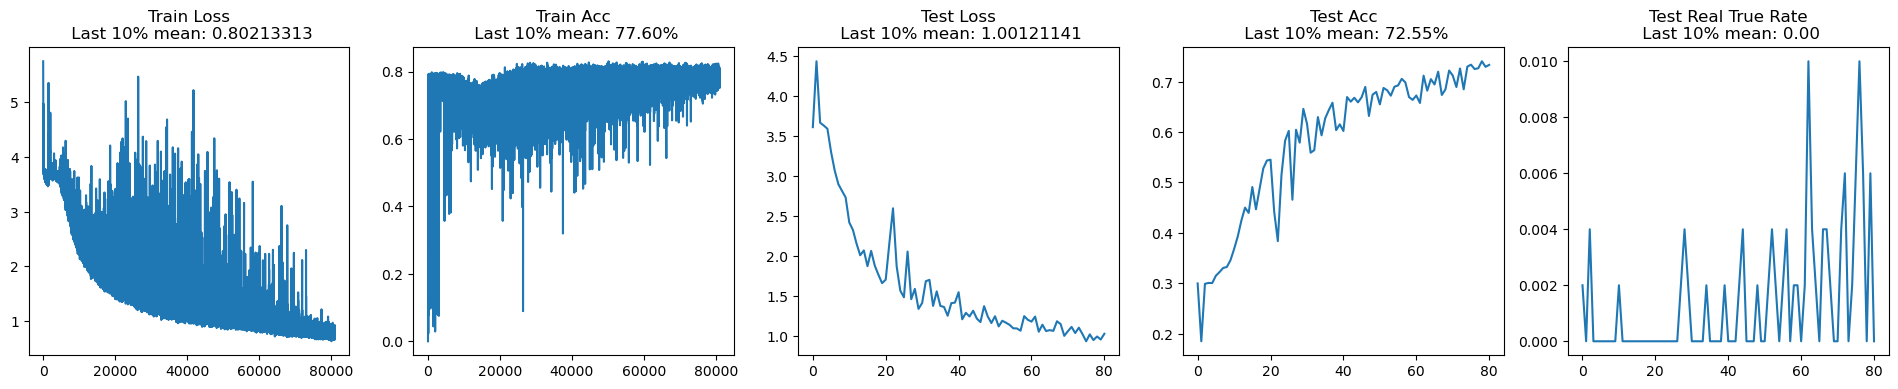

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

log_dir = './checkpoints_mae'

# load the logger
with open(log_dir + '/logger_train_loss.pkl', 'rb') as f:
    logger_train_loss = pickle.load(f)
with open(log_dir + '/logger_train_acc.pkl', 'rb') as f:
    logger_train_acc = pickle.load(f)
with open(log_dir + '/logger_test_loss.pkl', 'rb') as f:
    logger_test_loss = pickle.load(f)
with open(log_dir + '/logger_test_acc.pkl', 'rb') as f:
    logger_test_acc = pickle.load(f)
with open(log_dir + '/logger_test_real_true_rate.pkl', 'rb') as f:
    logger_test_real_true_rate = pickle.load(f)


# plot the logger curves

visualization_num = int(len(logger_test_loss)*0.1)

plt.figure(figsize=(24, 4))

plt.subplot(1,5,1)
plt.plot(logger_train_loss)
train_loss_last = np.mean(logger_train_loss[-visualization_num:])
plt.title('Train Loss\n Last 10% mean: {:.8f}'.format(train_loss_last))

plt.subplot(1,5,2)
plt.plot(logger_train_acc)
train_acc_last = np.mean(logger_train_acc[-visualization_num:])
plt.title('Train Acc\n Last 10% mean: {:.2%}'.format(train_acc_last))

plt.subplot(1,5,3)
plt.plot(logger_test_loss)
test_loss_last = np.mean(logger_test_loss[-visualization_num:])
plt.title('Test Loss\n Last 10% mean: {:.8f}'.format(test_loss_last))

plt.subplot(1,5,4)
plt.plot(logger_test_acc)
test_acc_last = np.mean(logger_test_acc[-visualization_num:])
plt.title('Test Acc\n Last 10% mean: {:.2%}'.format(test_acc_last))

plt.subplot(1,5,5)
plt.plot(logger_test_real_true_rate)
test_real_true_rate_last = np.mean(logger_test_real_true_rate[-visualization_num:])
plt.title('Test Real True Rate\n Last 10% mean: {:.2f}'.format(test_real_true_rate_last))


plt.show()

## visualization of testing new fastest trajectories

### load model

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import networkx as nx

from utils import transfer_graph, transfer_table_to_matrix
from model_mae import no_diffusion_model
from data_loader import data_loader_random_start as data_loader

device = 'cuda:0'

# load model
i = 80000
checkpoint_dir = './checkpoints_mae'
vocab_size = 242
n_embd, n_embd, n_layer, n_head, block_size, dropout, use_adj_table = args.n_embd, args.n_embd, args.n_layer, args.n_head, args.block_size, args.dropout, args.use_adj_table
model= no_diffusion_model(vocab_size, n_embd, n_embd, n_layer, n_head, block_size, dropout, weight_quantization_scale = None, use_adj_table=use_adj_table, use_ne=True, use_ge=True, use_agent_mask=False, norm_position='prenorm', device=device)
model.load_state_dict(torch.load(checkpoint_dir + '/complete_model_{}.pth'.format(i)).state_dict())
model.to(device)
model = model.eval()

### compare time

In [4]:

# load data
test_num = 2500
total_trajectories = 1
loader = data_loader(simulation_num=500,use_given_data= False,block_size= block_size)
# test_trajectory, test_adj_table, test_condition, special_mask = loader.load_train_batch(10, total_trajectories)
# for i in range(10):
#     for j in range(total_trajectories):
#         print(f'sampel{i}')
#         print(test_trajectory[i,j])
#         print(test_adj_table[i,j])
#         print(test_condition[i,j])
#         print(special_mask[i,j])
# test_trajectory, test_adj_table, test_condition, special_mask = loader.load_test_batch(10, total_trajectories)
# for i in range(10):
#     for j in range(total_trajectories):
#         print(f'sampel{i}')
#         print(test_trajectory[i,j])
#         print(test_adj_table[i,j])
#         print(test_condition[i,j])
#         print(special_mask[i,j])


test_trajectory, test_adj_table, test_condition, special_mask = loader.generate_batch(test_num, total_trajectories)
adj_matrix = [transfer_table_to_matrix(table) for table in test_adj_table]
adj_matrix = np.array(adj_matrix)
adj_matrix_tensor = torch.tensor(adj_matrix).to(device)
test_condition_tensor = test_condition.to(device).int()
test_adj_table_tensor = test_adj_table.to(device)
test_adj_table_tensor[:,:,:,1] = (test_adj_table_tensor[:,:,:,1]!=0).float()

test_trajectory = test_trajectory.cpu().numpy().astype(np.int32)
test_adj_table = test_adj_table.cpu().numpy()
test_condition = test_condition.cpu().numpy().astype(np.int32)


# model forward
start_time = time.time()
with torch.no_grad():
    # logits = model.test(test_condition, test_adj_table)
    logits, _ = model(test_condition_tensor, test_adj_table_tensor)
    model_time = time.time()
    # del model
    logits = logits.cpu().numpy()
    predic_trajectory = np.argmax(logits, axis=-1)
    # predic_trajectory = torch.argmax(logits, dim=-1)
    transfer_time = time.time()
print('Model Time:',model_time-start_time, 'Transfer Time:',transfer_time-model_time)
# predic_trajectory = predic_trajectory.cpu().numpy().astype(np.int32)

Model Time: 0.5246660709381104 Transfer Time: 1.6341757774353027


### print trajectory

In [5]:
# print the trajectory
from utils import print_trajectory

print('Without correction:')

print(test_trajectory.shape)
print_trajectory(predic_trajectory, test_trajectory, test_condition)

Without correction:
(2500, 1, 51)
weighted graph 1  , true 1  : [168 167  84 203 233 129 130 162  86  55  56   9   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
weighted graph 1  , pred 1  : [168 167  84 203 233 129 130 162  86  55  56   9 114 115 180 101 102 103
 104 228   0   0   0   0   0   0   0   0   0   0   0   0   0   0 111 129
  76 115 115 115 109 109 156   0  88  88  88 218 218 218 218]
weighted graph 1  , condition: [168   0   0   0   0   0   0   0   0   0   0   9   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
weighted graph 2  , true 1  : [ 86 201 202 203 233 129 130 162   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
weighted grap

### plot trajectory

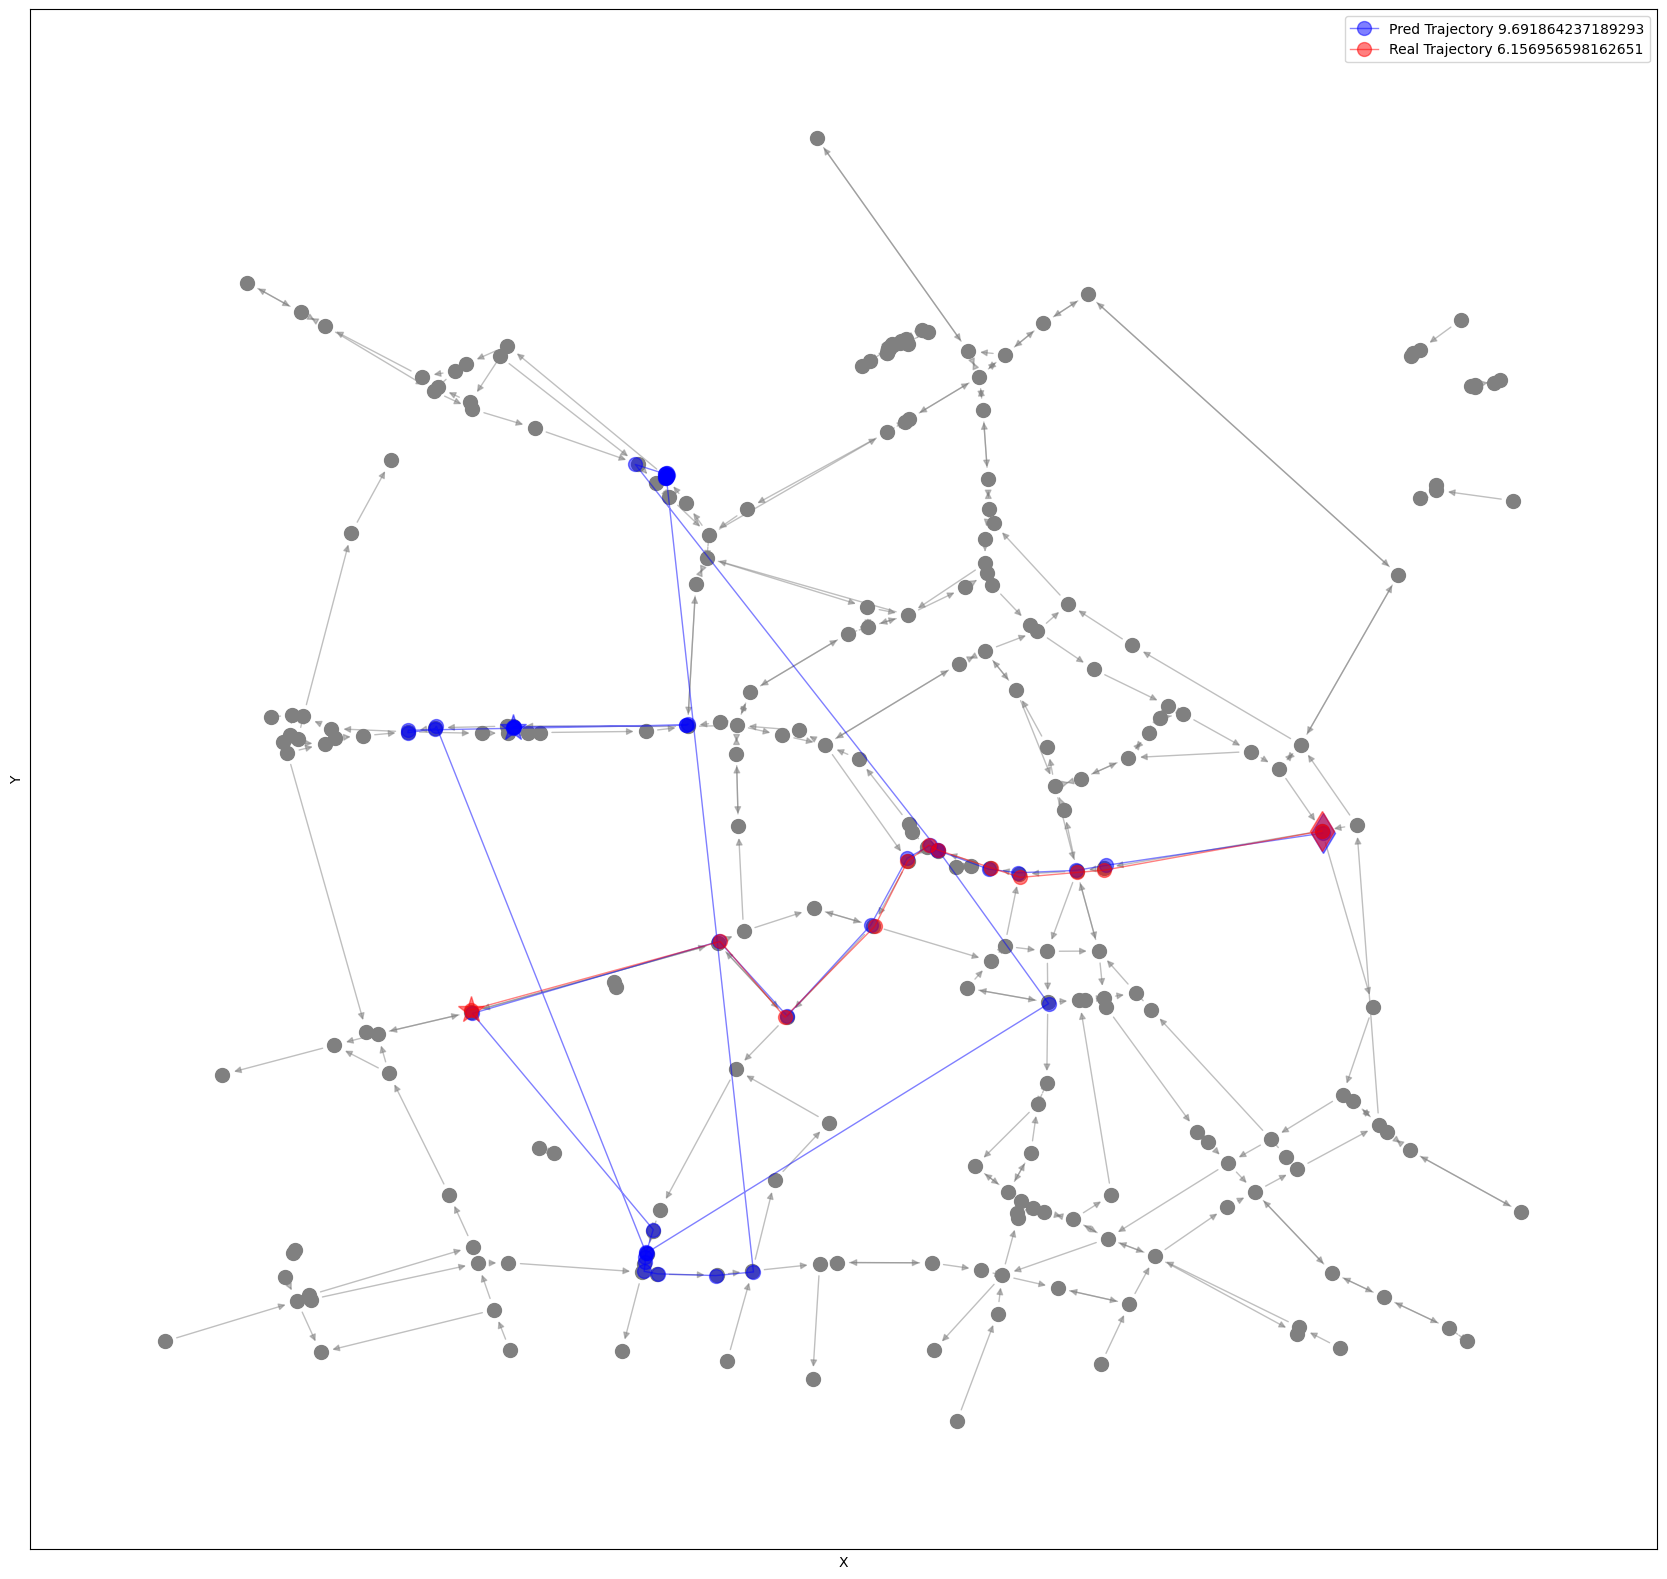

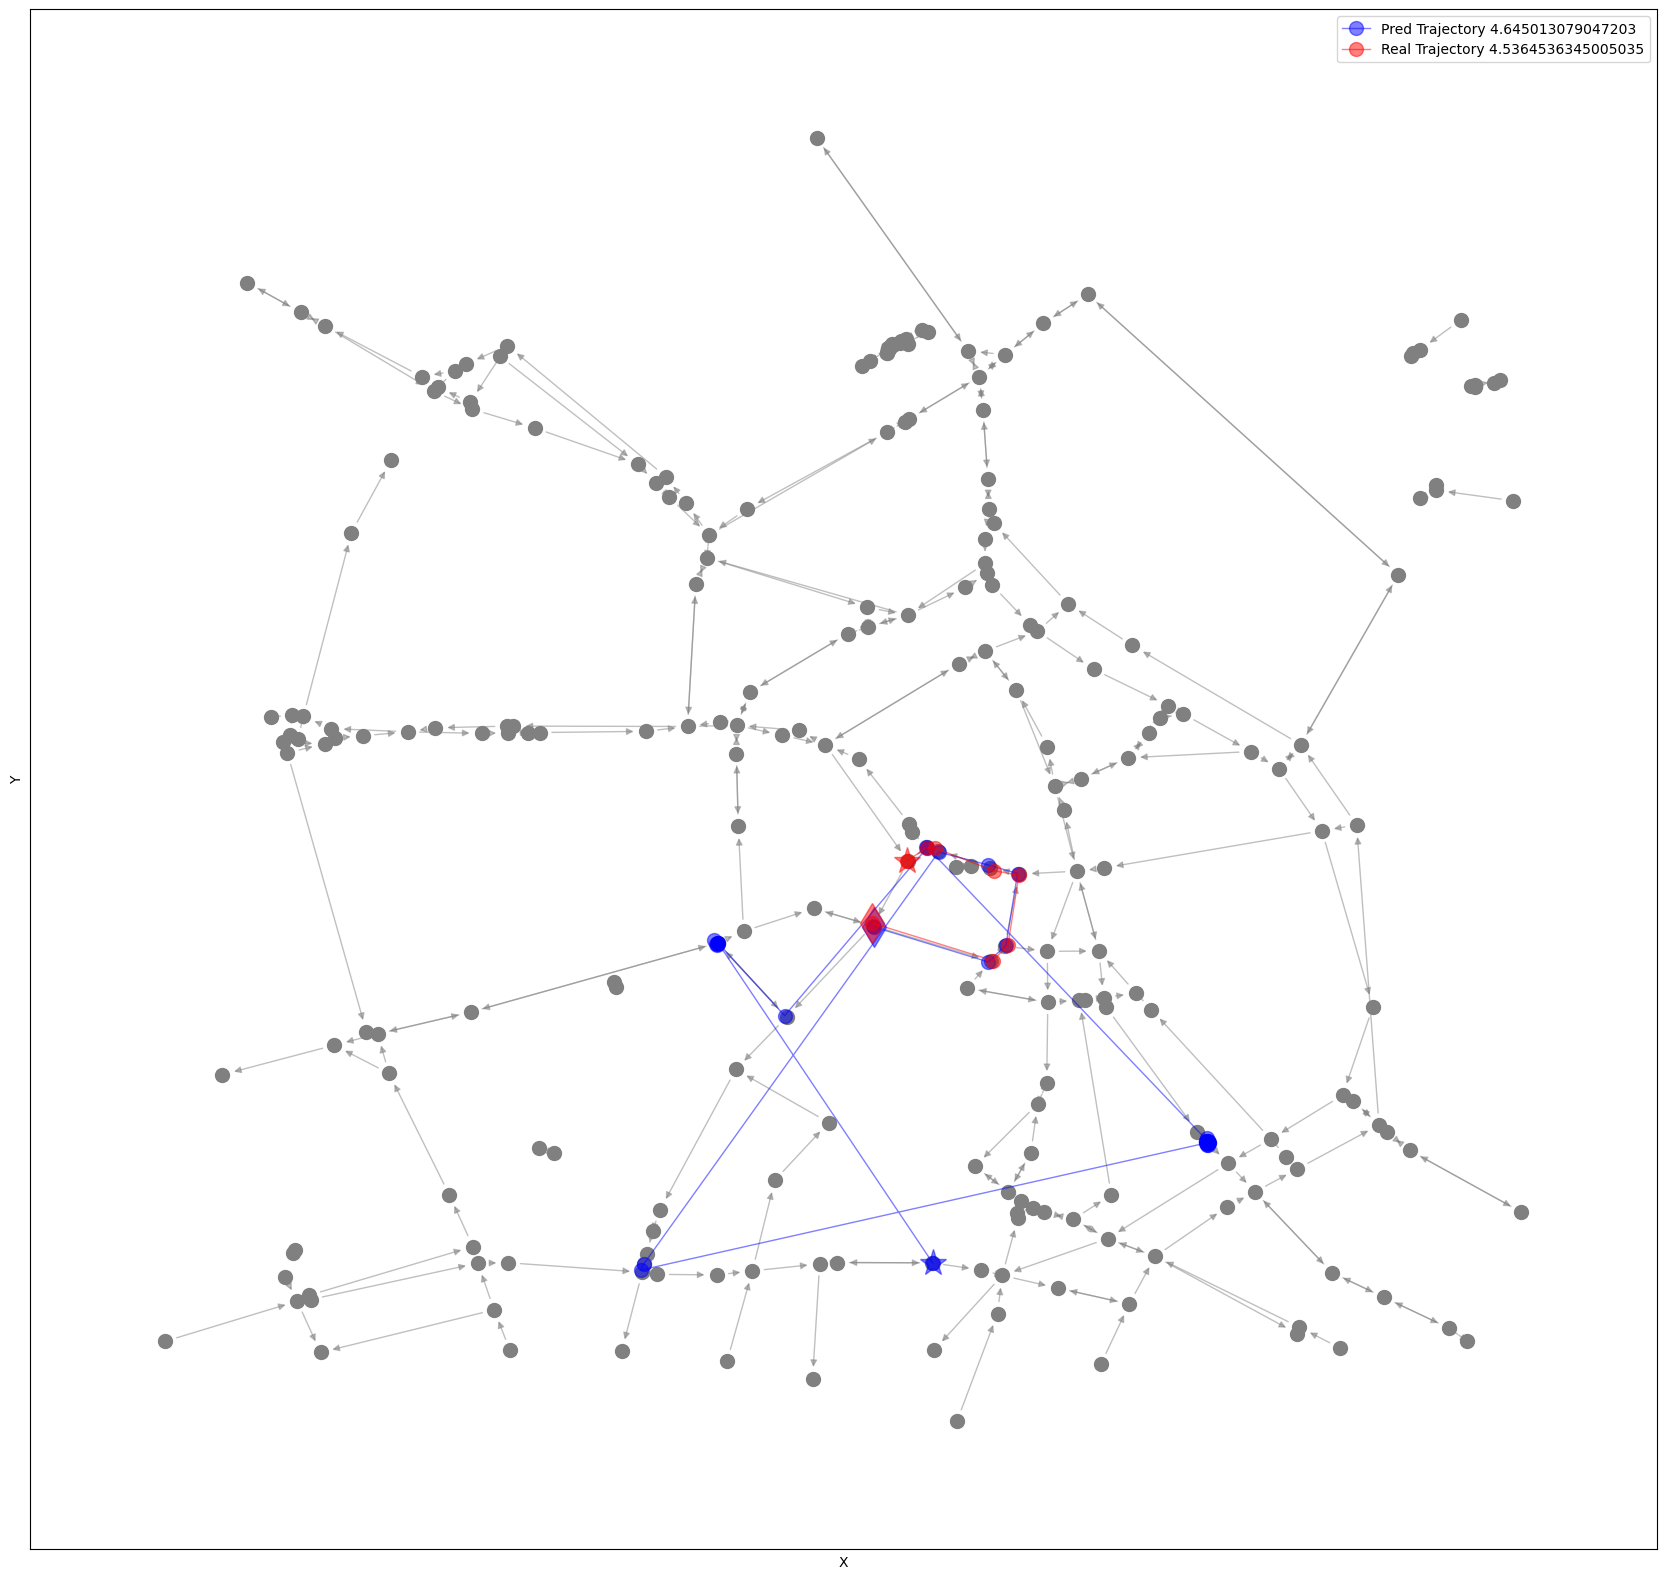

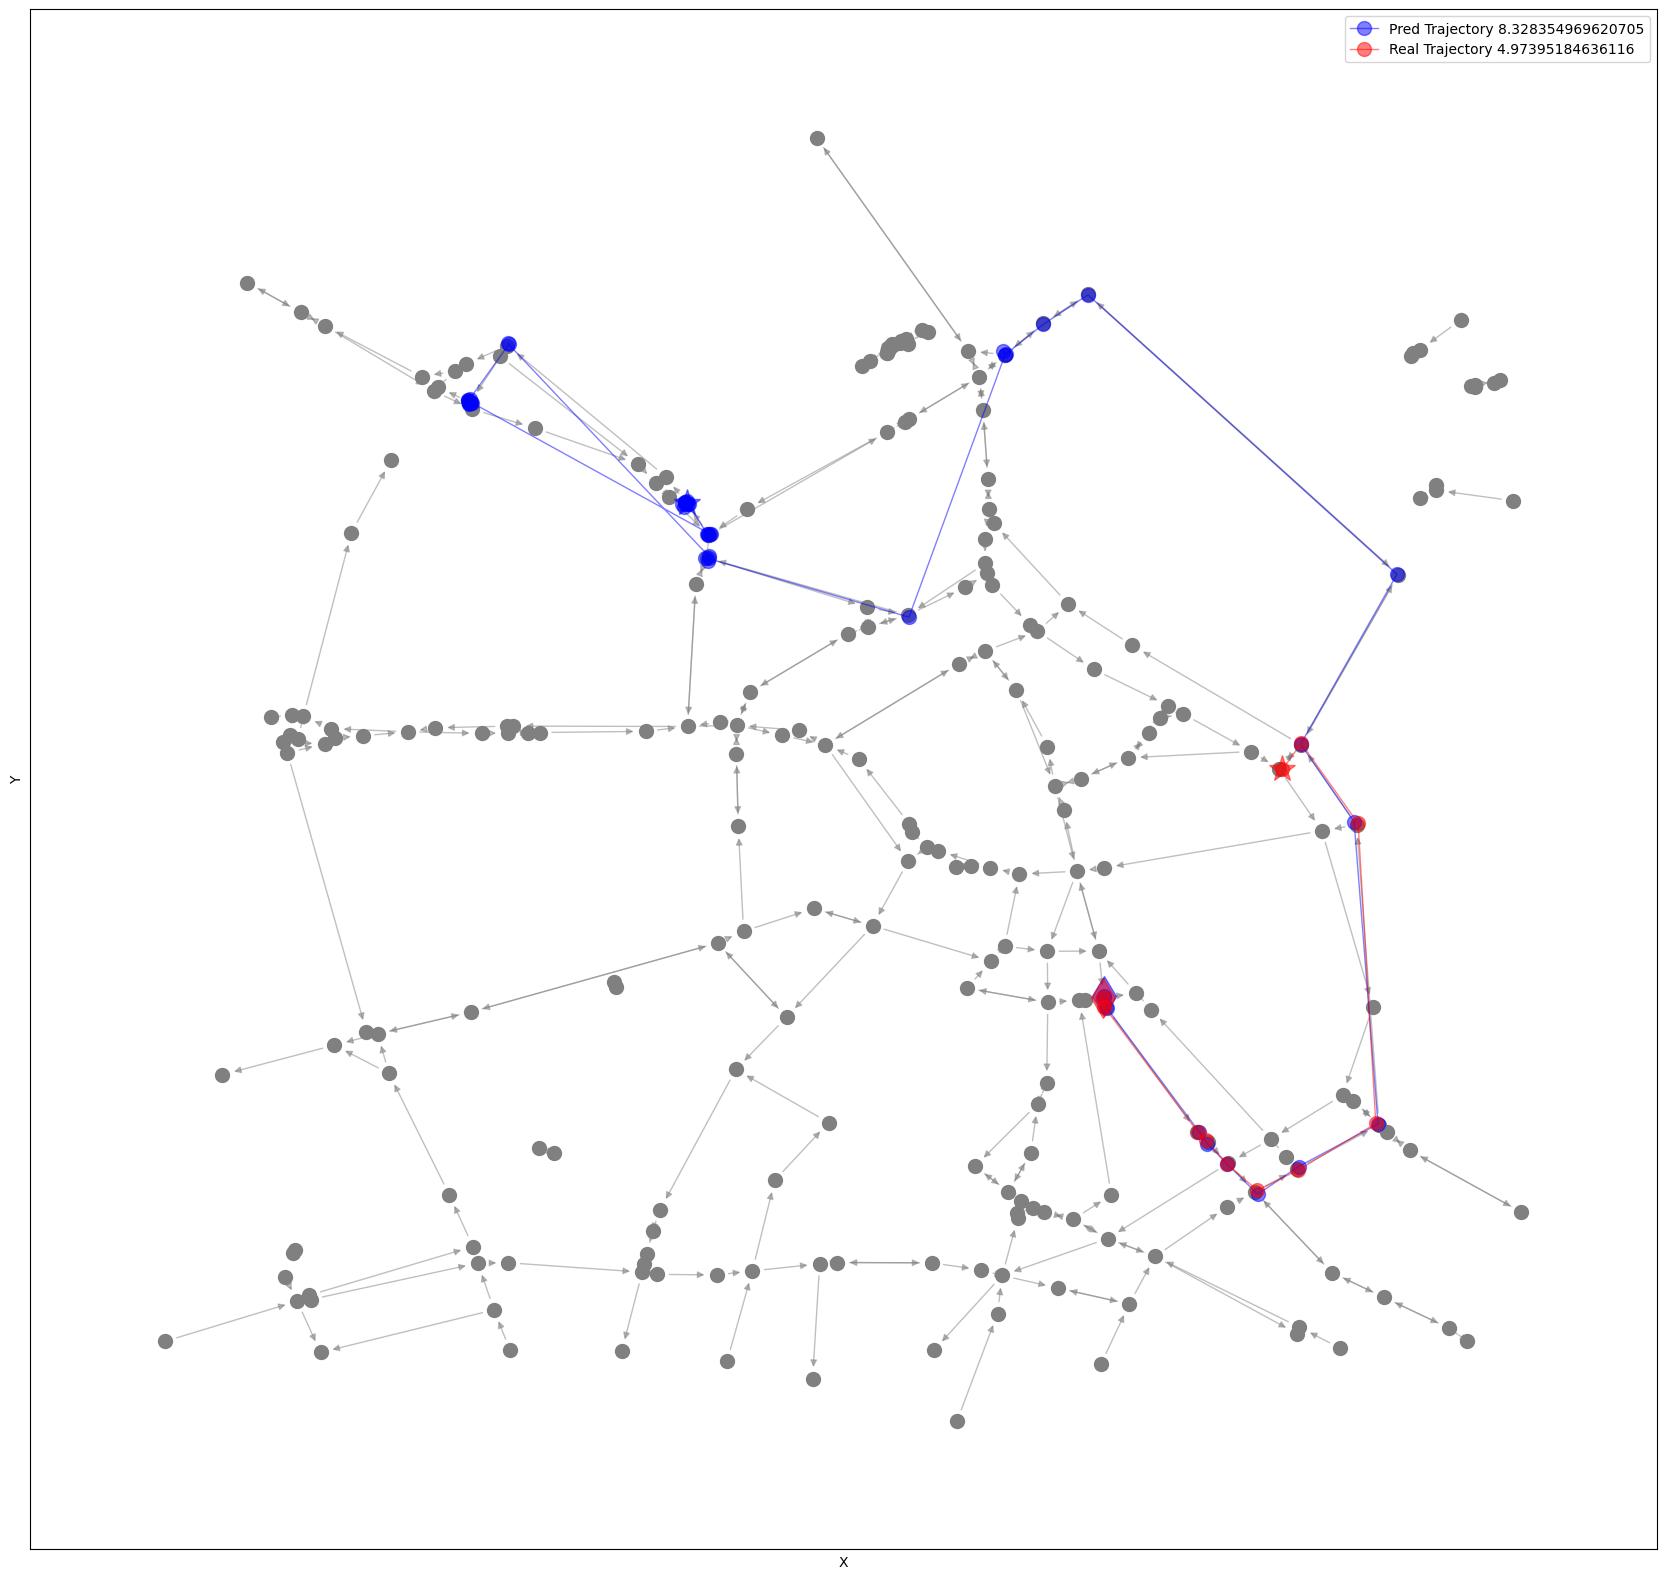

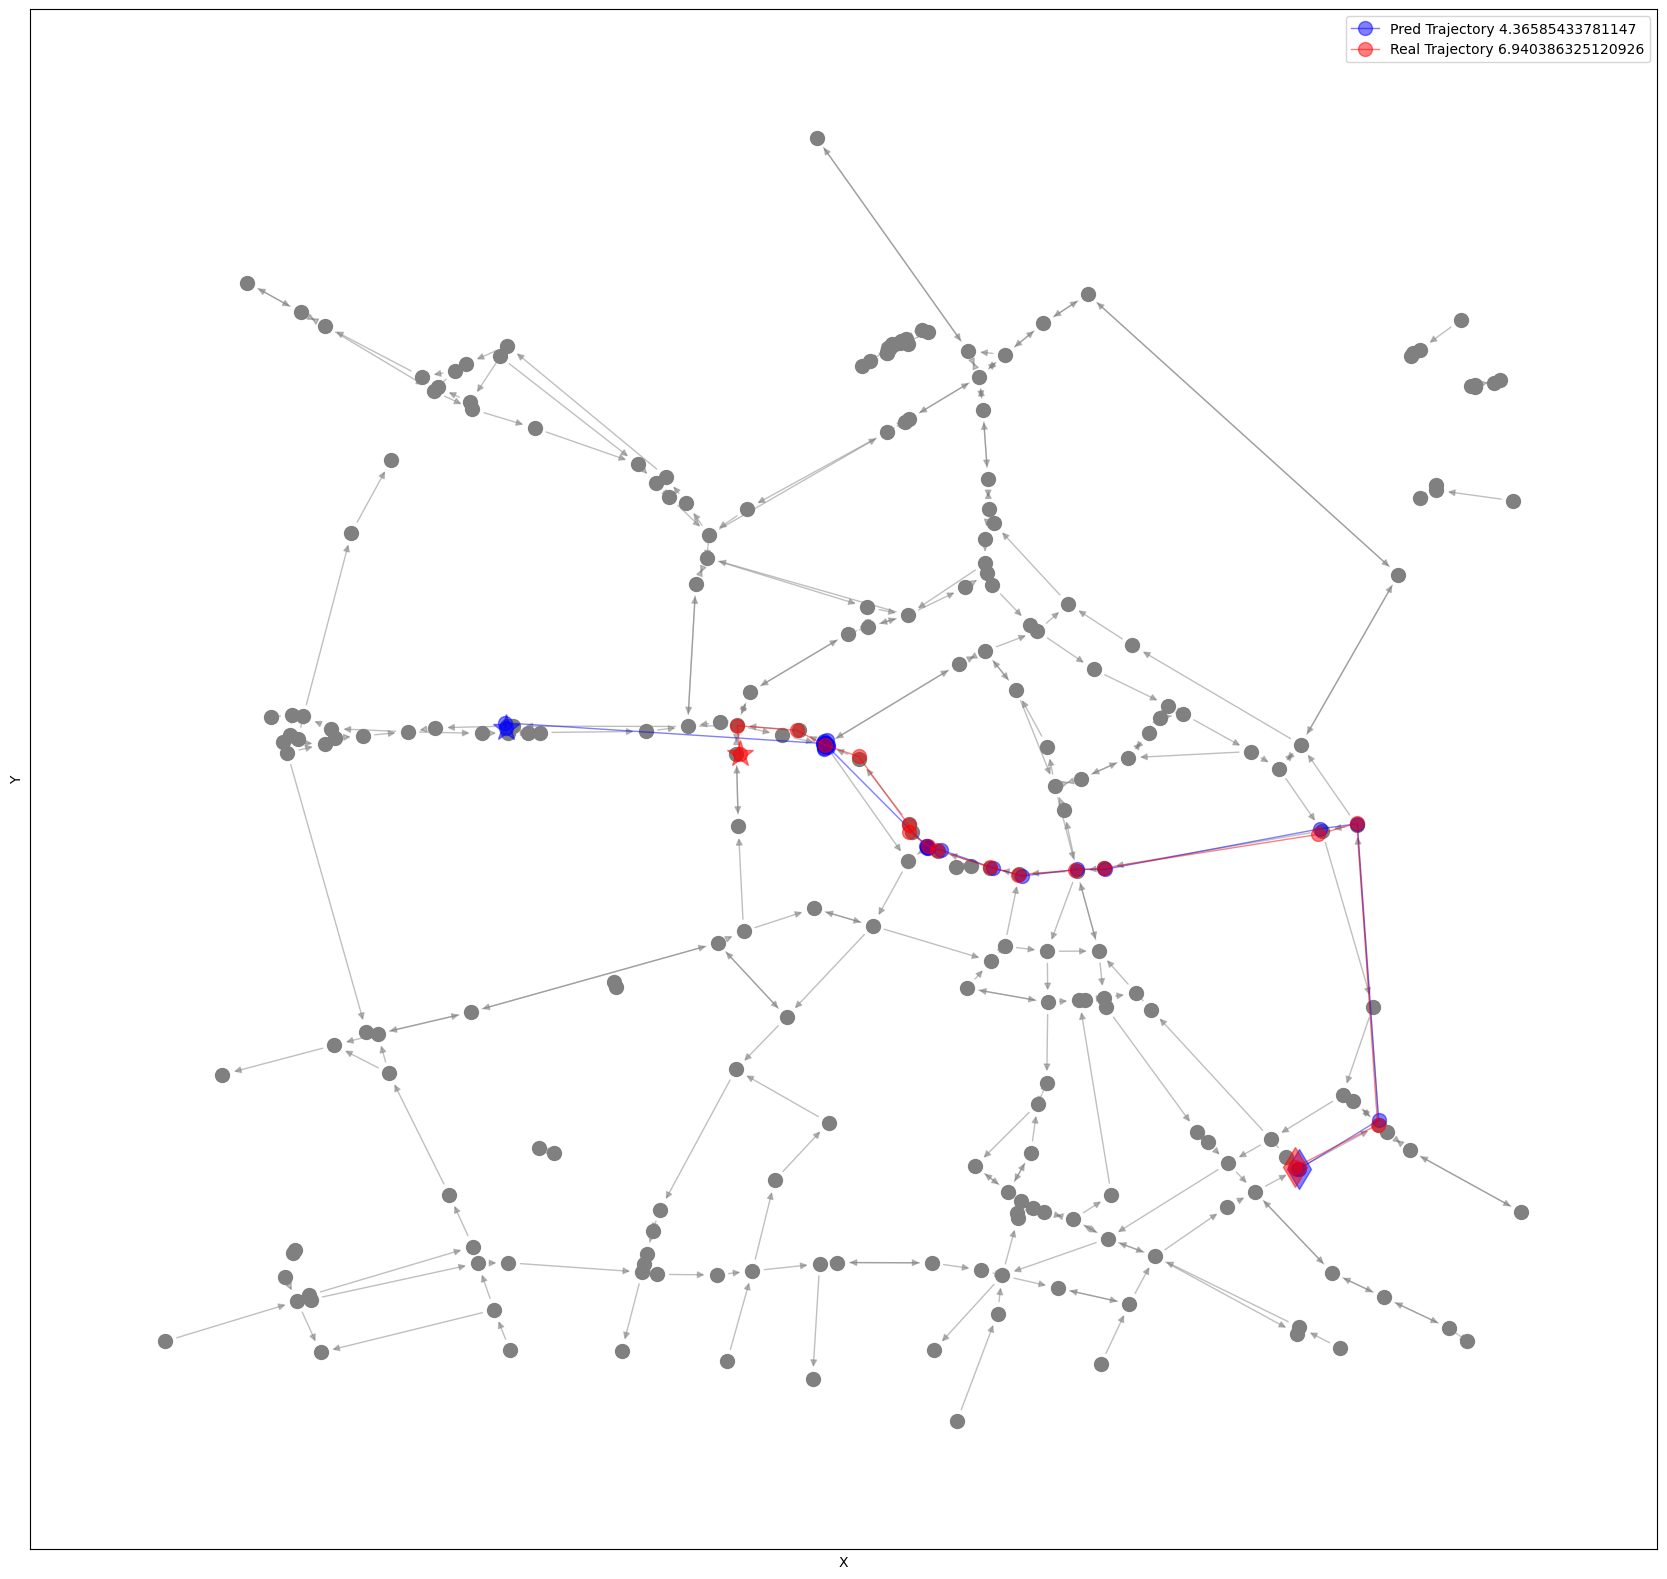

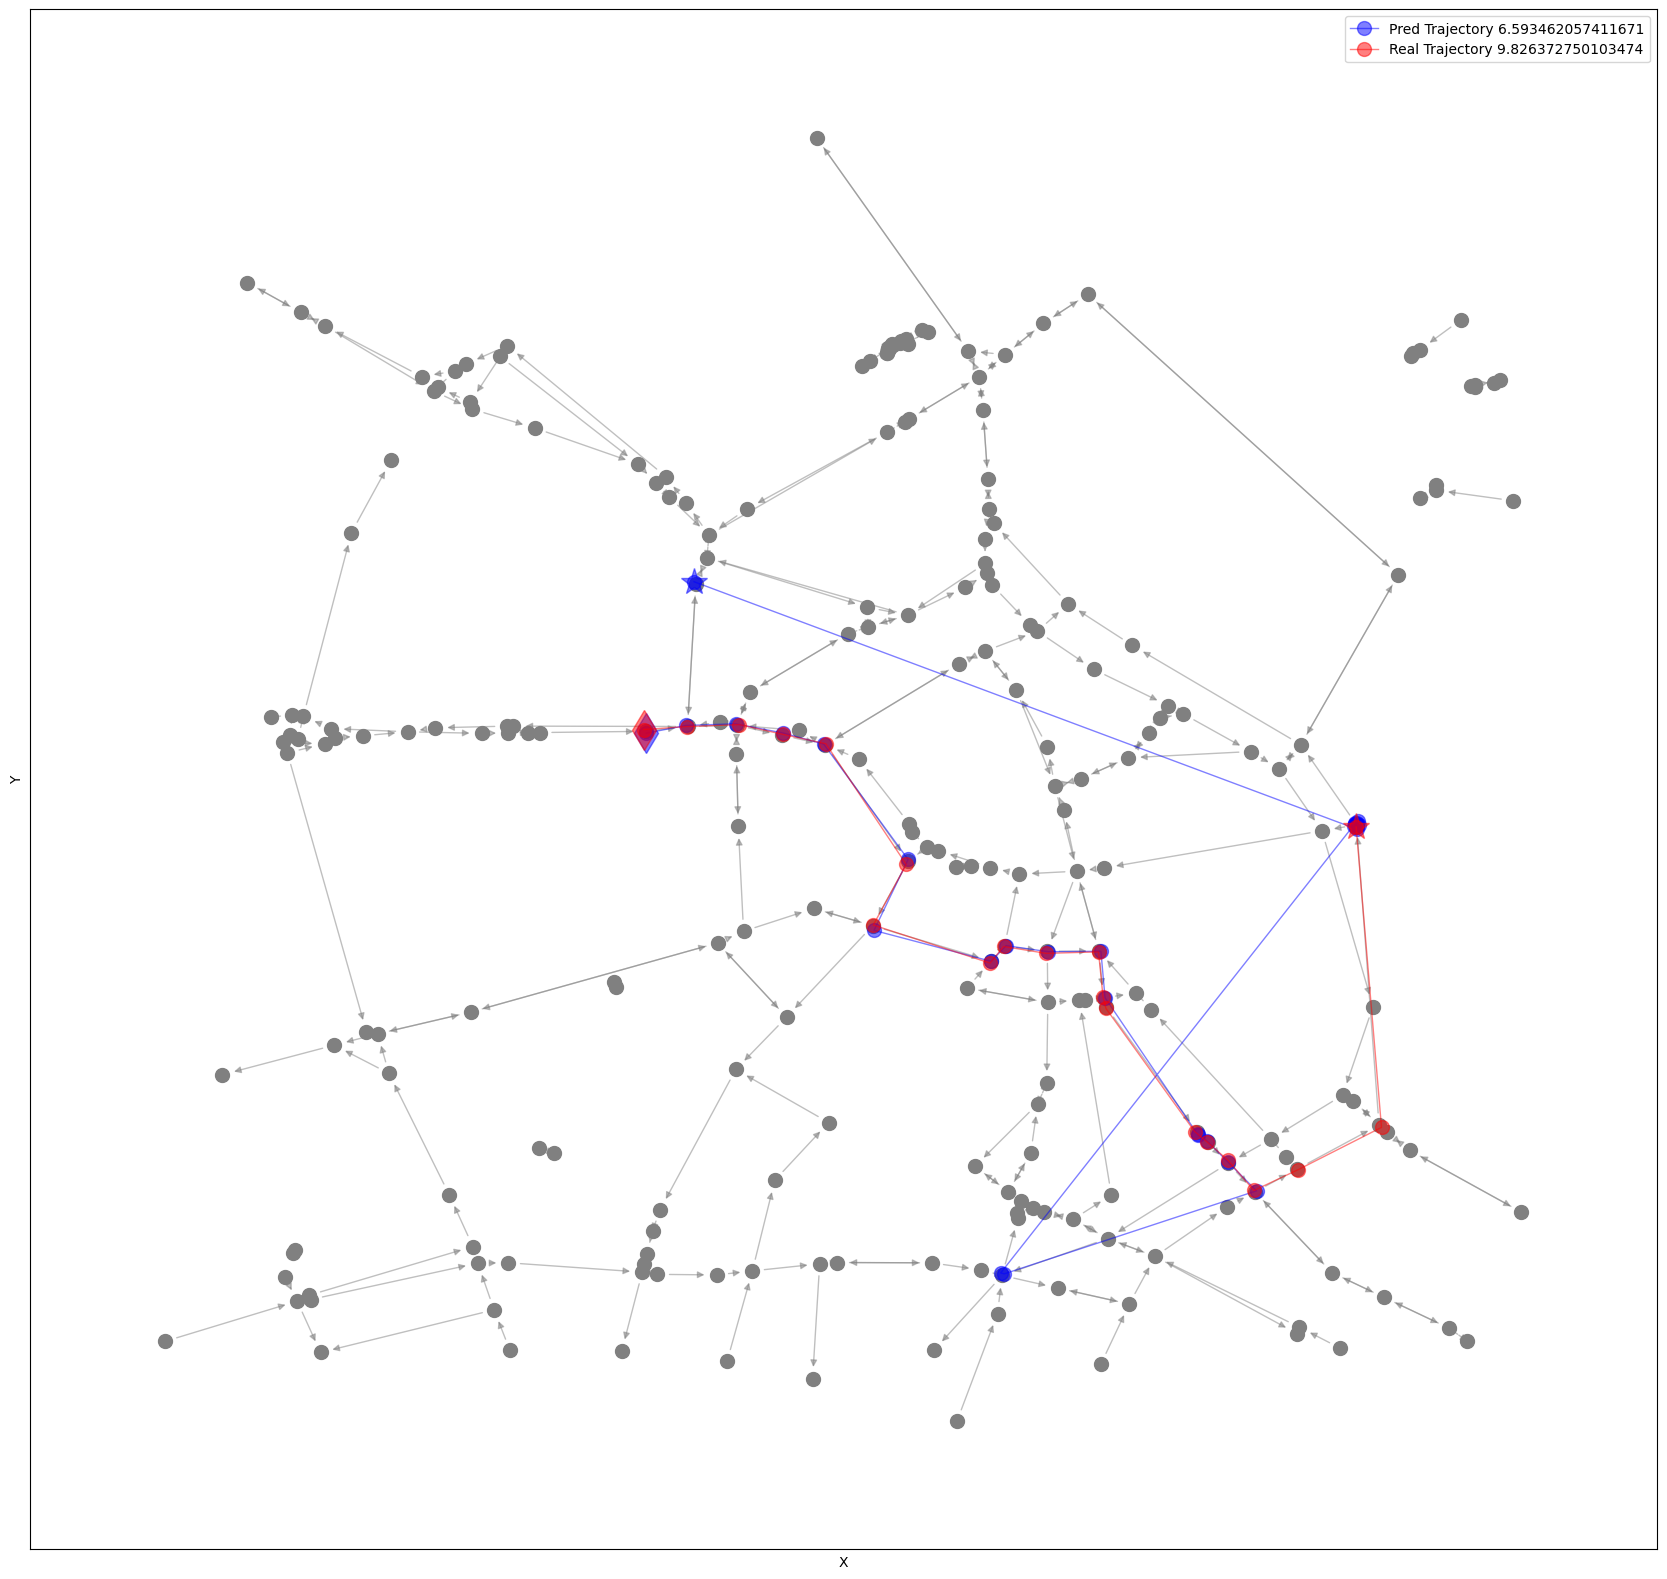

In [6]:
# plot the trajectory
from utils import plot_trajs, remove_special_token
from dataset import read_city

_, pos = read_city('boston')

fig_size = 20
plot_num = min(5, test_num)

for i in range(plot_num):
    fig, ax = plt.subplots(1, total_trajectories, figsize=((fig_size+1)*total_trajectories, fig_size))
    for j in range(total_trajectories):
        traj = predic_trajectory[i,j] # (block_size,)
        traj_ = test_trajectory[i,j] # (block_size,)
        traj = remove_special_token(traj)
        traj_ = remove_special_token(traj_) # original 1-index, now 0-index

        test_weight_adj = transfer_table_to_matrix(test_adj_table[i])
        G = transfer_graph(test_adj_table[i])
        if total_trajectories == 1:
            plot_trajs(ax, G, pos, test_weight_adj, traj, traj_, ground_truth=False)
        else:
            plot_trajs(ax[j], G, pos, test_weight_adj, traj, traj_, ground_truth=False)
    plt.show()
